In [1]:
import os
import ee
import fiona
import datetime 
import itertools
import numpy as np
import pandas as pd
import rsfuncs as rs
import seaborn as sns
import rasterio as rio
import geopandas as gp

from tqdm import tqdm 
from collections import OrderedDict 
from datetime import datetime, timedelta
from datetime import date as dt_date
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from matplotlib.lines import Line2D
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from descartes import PolygonPatch
from itertools import combinations
from collections import OrderedDict 

ee.Initialize()

In [2]:
# Lookup table with product names and EE ids 

prod_lookup = {
    'disal' : ee.ImageCollection("users/aguzman/Kaweah_disalexi"),
    'metric' : ee.ImageCollection("users/aguzman/Kaweah_eemetric"),
    'ptjpl' : ee.ImageCollection("users/aguzman/Kaweah_ptjpl"),
    'sebal': ee.ImageCollection("users/aguzman/Kaweah_sebal"),
    'sims' : ee.ImageCollection("users/aguzman/Kaweah_sims"),
    'ssebop' : ee.ImageCollection("users/aguzman/Kaweah_ssebop")
}

# read shapefile
kaweah = gp.read_file("../shape/kb_rpj.shp")
k_area_km2 = float(kaweah.to_crs({'init': 'epsg:32611'}).area * 1e-6)
kaweah.crs = {"init":"epsg:4326"}

/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
# Read the OpenET tiffs generated from Fetch_OpenET.ipynb 

et_dict = {}

for prod in list(prod_lookup.keys())[:]:
    
    print(prod)
    
    # find the dir of merged rasters processed in fetch_openET
    merged_dir = "../rasters/openet/{}/merged".format(prod)
    merged_files = [os.path.join(merged_dir,x) for x in os.listdir(merged_dir)]
    
    # I goofed and didn't zpad the time index on the files in prev script..
    # So when you run sorted(files) t_11 goes before t_2,t_3,t_4 etc. So am renaming the files here with the extra char
    # then things get sorted in the right order. TODO fix this in OG script if I ever have time. 
    for idx,filename in enumerate(sorted(merged_files)):
        fn = filename.split(".tif")[0]
        tidx = fn.find("_t") + 2
        tidxint = fn[tidx:]
        if len(tidxint) == 1: # it wont run if already zpadded or >9. 
            print(filename)
            tidxstr = "0" + tidxint
            new_fn = fn.replace(tidxint,tidxstr) + ".tif"
            os.rename(filename, new_fn)
            
    # Get the enddates from the image collections metadata (data are monthly sums)
    iminfo = prod_lookup[prod].getInfo()
    end_date = iminfo['features'][0]['properties']['end_date']
    
    # create time index from end time - length of timeseries
    dt_start = datetime.strptime(end_date, '%Y-%m-%d')
    dt_end = dt_start + relativedelta(months=len(merged_files)-1)
    dt_idx = pd.date_range(dt_start, dt_end, freq = "M")
    
    # Read the files as np arrays
    imdict = {}
    
    for dt,fn in tqdm(zip(dt_idx,sorted(merged_files))):
        datestr = dt.strftime('%Y%m%d') # Format date
        src = rio.open(fn) # Read file
        arr = src.read(1)
        imdict[datestr] = arr
        
    # Stack all dates to 3D array
    et_stack = np.dstack(list(imdict.values()))

    # Compute monthly sums
    etsums = []
    for i in range(et_stack.shape[2]):
        etsums.append(np.nansum(et_stack[:,:,i] * 1e-6* .03 * .03 )) # mm --> km * cell_x(km) cell_y(km) = km^3

    # Make dataframe and write to dict
    etdf = pd.DataFrame(etsums, index = dt_idx)
    etdf.columns = ["et_km3_{}".format(prod)]
        
    et_dict[prod] = etdf

disal


60it [00:12,  4.90it/s]


metric


60it [00:12,  4.67it/s]


ptjpl


60it [00:16,  3.65it/s]


sebal


60it [00:12,  4.99it/s]


sims


60it [00:10,  5.47it/s]


ssebop


60it [00:11,  5.36it/s]


In [20]:
# Unpack the dict of dataframes

et_df_all = []

for k,v in et_dict.items():
    et_df_all.append(v)
    
etdf_out = pd.concat(et_df_all,axis = 1)

In [21]:
####### TRIPLE COLLOCATION FUNCTIONS #######

def calc_tc_error(x,y,z):
    '''
    calculate errors between triplets
    '''
    e_x = np.sqrt(np.abs(np.mean((x - y) * (x - z))))
    e_y = np.sqrt(np.abs(np.mean((y - x) * (y - z))))
    e_z = np.sqrt(np.abs(np.mean((z - x) * (z - y))))

    return e_x, e_y, e_z

def scale_to_ref(src, ref):
    '''
    scale one dataset to another (mean / std)
    '''
    return ((src - np.nanmean(src)) / np.nanstd(src)) * np.nanstd(ref) + np.nanmean(ref)


def do_tc(df):
    '''
    wrapper for calc_tc_error applied to a df 
    '''
    tc_dict = df.astype(float).to_dict('list')
    combos=itertools.permutations(tc_dict, 3) 

    err_dict = {k:[] for k in tc_dict}

    for idx,i in enumerate(combos):

        x = tc_dict[i[0]]
        y = tc_dict[i[1]]
        z = tc_dict[i[2]]

        y_scaled = scale_to_ref(y,x)
        z_scaled = scale_to_ref(z,x)

        e_x, e_y, e_z = calc_tc_error(x, y_scaled, z_scaled)

        err_dict[i[0]].append(e_x)
        err_dict[i[1]].append(e_y)
        err_dict[i[2]].append(e_z)
        
    return err_dict
    

######## PLOTTING FUNCS #########
def monthly_annual(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (13,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.25)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()
    if not var == "ET":
        ydf.resample("Y").sum().boxplot(ax = ax1)
    else:
        ydf.resample("Y").sum().mean().boxplot(ax = ax1, showfliers=False)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 60, fontsize = 14)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k], label = k)

    labels = [str(dt_date(1900, x, 1).strftime('%B'))[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    plt.legend(loc="upper right", ncol = 1,bbox_to_anchor=(1.45, 1.),
               fancybox=True,  prop={'size': 13})
    plt.style.use('default')
    plt.show()
    
def timeseries(df,coldict,var):
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    fig = plt.figure(figsize = (12,4))
    
    # Boxplot
    ax5 = fig.add_subplot(111)
    
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.29),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)
    plt.show()

def corr_err(df,coldict,var):

    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (12,3))
    gs = fig.add_gridspec(1, 2, hspace = 0.7,wspace = 0.15)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 0:1])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 1:2])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.suptitle(var, size = 20)
    plt.tight_layout()
    plt.style.use('default')
    plt.show()
    
    
def make_plots(df, coldict, var):
    '''
    wrapper for all previous funcs
    
    for a dataframe of a single variable and a dict mapping col names to datasets, return:
    1) mean annual boxplot, 
    2) mean monthly scatterplot, 
    3) full timeseries, 
    4) correlation plot
    5) Triple collocation error box plot
    '''
    colors = sns.color_palette()
    cdict = OrderedDict(zip(list(coldict.values()),colors))

    # setup
    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.55)
    
    # Boxplot
    ax1 = fig.add_subplot(gs[0:1, :1])
    ydf = df.copy()

    ydf.resample("Y").sum().boxplot(ax = ax1, showfliers=False)
        
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90, fontsize = 12)
    ax1.set_ylabel("{} (mm)".format(var), size = 16)
    ax1.set_title('Annual Mean', size = 16)
    
    # # Monthly mean plot with errs
    ax2 = fig.add_subplot(gs[0:1, 1:3])
    monthly = df.groupby(df.index.month).mean()
    errs= df.groupby(df.index.month).std()
    
    for k,v in cdict.items():
        ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k])

    labels = [dt_date(1900, x, 1).strftime('%B')[:3] for x in df.groupby(df.index.month).mean().index]
    ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
    ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
    ax2.set_title("Monthly Mean", size = 16)

    # Corr mat
    ax3 = fig.add_subplot(gs[0:1, 3:4])
    sns.heatmap(df.corr(),annot=True,fmt=".2f", ax = ax3, vmin = 0, vmax = 1, cmap = sns.diverging_palette(300, 145, s=60, as_cmap=True))
    ax3.set_title('Correlation Matrix', size = 16)
    ax3.tick_params(labelsize=14)
    
    # Tc error    
    ax4 = fig.add_subplot(gs[0:1, 4:5])
    dropcols = [x for x in df.columns if "Reservoir" in x ] # or "Q" in x]
    tcdf = df.drop(dropcols, axis = 1)
    pd.DataFrame.from_dict(do_tc(tcdf.dropna())).boxplot(ax = ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation = 90, fontsize = 14)
    ax4.set_title('TC error (mm)', size = 16)
    
    plt.tight_layout()
    plt.style.use('default')
    plt.show()

    fig = plt.figure(figsize = (19,7))
    gs = fig.add_gridspec(2, 5, hspace = 0.7,wspace = 0.38)
    # Time series
    ax5 = fig.add_subplot(gs[-1, :-1])
    for k,v in cdict.items():
        df[k].plot(ax = ax5,x_compat=True,color = v)

    ax5.xaxis.set_tick_params(reset=True)
    ax5.xaxis.set_major_locator(mdates.YearLocator(1))
    ax5.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax5.set_xlim([df.index[0],df.index[-1]])
    ax5.set_title("{} Monthly Time Series".format(var), size = 15)
    leg = ax5.legend(loc="lower center", ncol = 6,bbox_to_anchor=(0.5, -0.5),
               fancybox=True,  prop={'size': 15})

    ax5.set_ylabel("{} (mm)".format(var), size = 16)

    plt.tight_layout()

    plt.style.use('default')
    plt.show()


In [22]:
etcoldict = {'et_km3_disal':'disalexi', 
                'et_km3_metric':'metric',  
                'et_km3_ptjpl':'pt-jpl',
                'et_km3_sebal': "sebal",
                'et_km3_ssebop': "ssebop",
                'et_km3_sims': "sims",
            }

In [25]:
etdf_all = etdf_out.loc[:, etdf_out.columns.isin(etcoldict.keys())]
etdf_all_plot = etdf_all.rename(columns = etcoldict)

<ipython-input-21-380548801476>:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


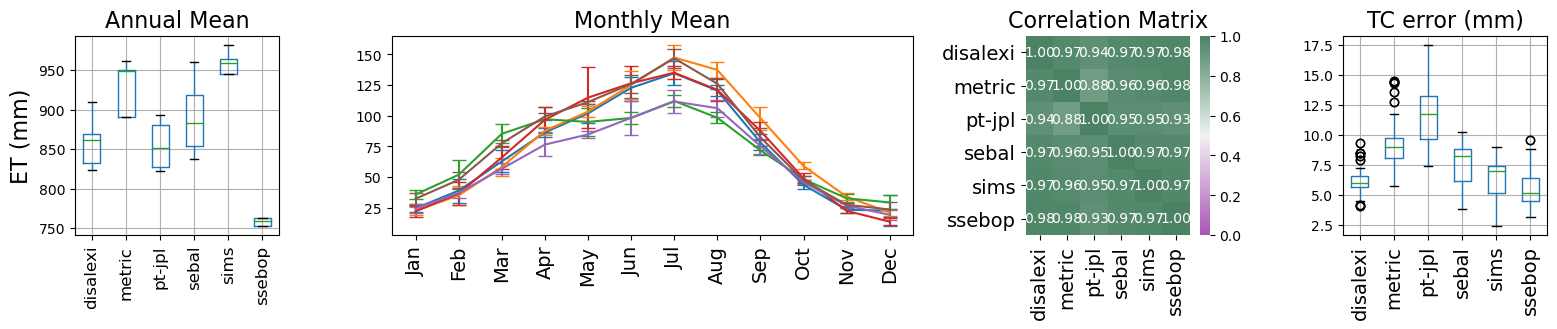

<ipython-input-21-380548801476>:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


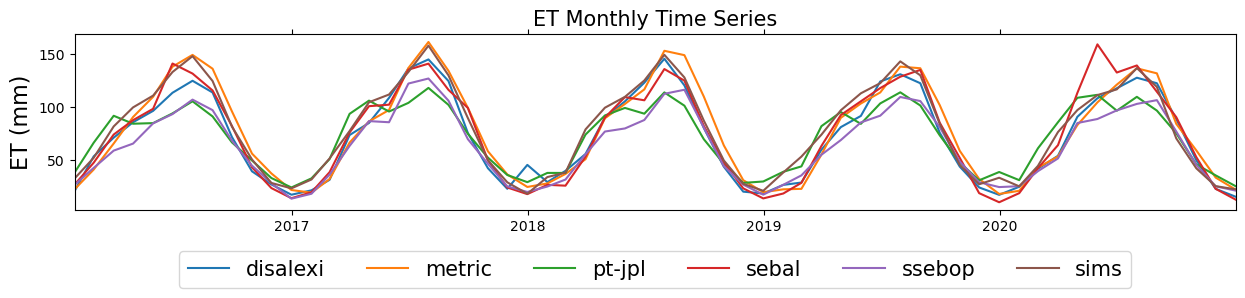

In [26]:
make_plots(etdf_all_plot/ k_area_km2 * 1e6,etcoldict,var='ET')


In [27]:
# Load ET data processed using crop coefficient method
modkc_et = rs.col_to_dt(pd.read_csv("../data/MODkc.csv"))['MODkc']
modkc_et.index = modkc_et.index + pd.offsets.MonthEnd(0) 
modkc_et.columns = ["MOD16_kc"]

# Load SSEBop ET data
ssebop_et =  rs.col_to_dt(pd.read_csv("../data/ssebop_et.csv"))
ssebop_et.index = ssebop_et.index + pd.offsets.MonthEnd(0) 
ssebop_et.columns = ["MOD_ssebop"]

# Load MOD16 / LSM based ET 
kawdf = rs.col_to_dt(pd.read_csv("../data/RS_analysis_dat.csv"))
kawdf_et = kawdf[["aet_modis", 'aet_gldas','aet_tc','aet_fldas']]

In [31]:
# Merge all 
etdf1 = pd.merge(etdf_all, modkc_et,left_index = True, right_index = True)
etdf2 = pd.merge(etdf1, ssebop_et,left_index = True, right_index = True)
etdf_f = pd.merge(etdf2, kawdf_et,left_index = True, right_index = True)

In [32]:
etdf_f.head()

,et_km3_disal,et_km3_metric,et_km3_ptjpl,et_km3_sebal,et_km3_sims,et_km3_ssebop,MODkc,MOD_ssebop,aet_modis,aet_gldas,aet_tc,aet_fldas
2016-01-31,0.074481,0.079751,0.136002,0.095504,0.115759,0.094431,0.096027,0.010380,0.065119,0.071726,0.124378,0.081502
2016-02-29,0.188215,0.144281,0.233745,0.167067,0.183481,0.149853,0.248936,0.031767,0.118482,0.126131,0.065696,0.143884
2016-03-31,0.250893,0.231344,0.323868,0.261210,0.288309,0.207596,0.323960,0.138739,0.167883,0.242054,0.167353,0.195812
2016-04-30,0.302401,0.319795,0.297376,0.309269,0.351911,0.231083,0.390029,0.180768,0.141128,0.286820,0.097381,0.184277
2016-05-31,0.340319,0.387246,0.299403,0.347164,0.391188,0.298576,0.447781,0.270439,0.096853,0.280919,0.046638,0.095291


<ipython-input-21-380548801476>:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


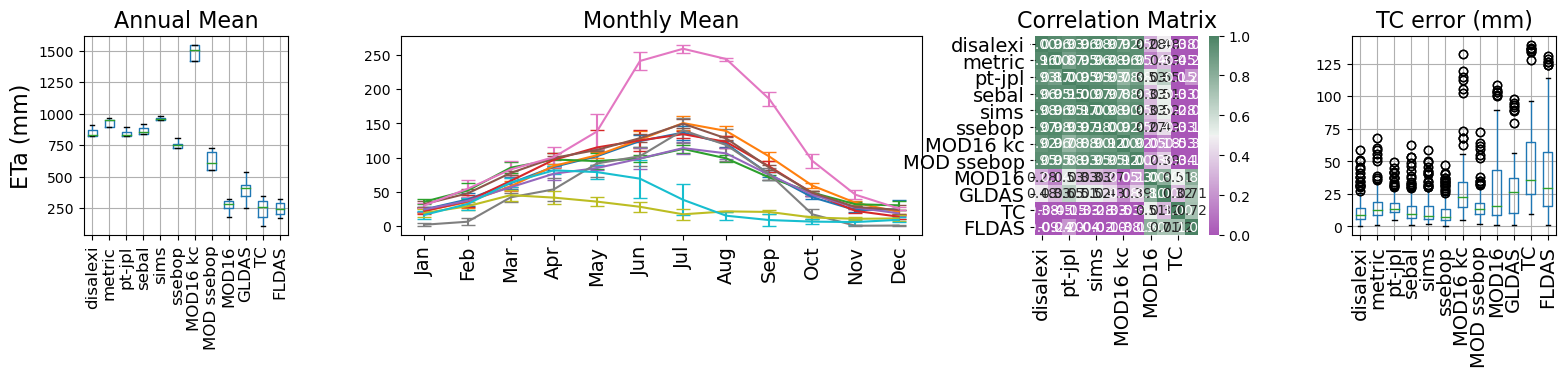

<ipython-input-21-380548801476>:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


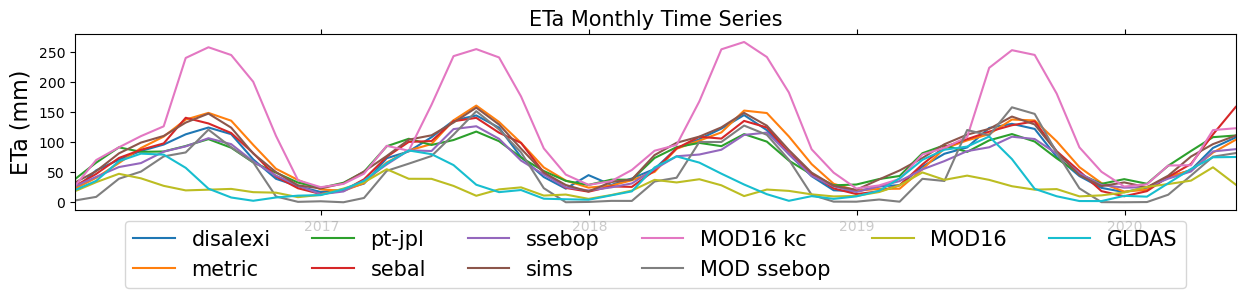

In [81]:
# Make plots for merged 
etcoldict_merge = {'et_km3_disal':'disalexi', 
                'et_km3_metric':'metric',  
                'et_km3_ptjpl':'pt-jpl',
                'et_km3_sebal': "sebal",
                'et_km3_ssebop': "ssebop",
                'et_km3_sims': "sims",
                'MODkc' : "MOD16 kc",
                'MOD_ssebop' : "MOD ssebop",
                'aet_modis' : 'MOD16',
                'aet_gldas' : "GLDAS",
                'aet_tc' : "TC",
                'aet_fldas':"FLDAS"}

etdf_2 = etdf_f.loc[:, etdf_f.columns.isin(etcoldict_merge.keys())]
etdf_merged_plot = etdf_2.rename(columns = etcoldict_merge)

make_plots(etdf_merged_plot / k_area_km2 * 1e6, etcoldict_merge, var = 'ETa')
           

# Process LandIQ data:

In [34]:
# Mask the landiq data 

shp = fiona.open("../shape/kb_utm.shp", "r")
mask = [pol['geometry'] for pol in shp]

In [35]:
liqimdict = {}

# Read the LandIQ files
LIQ_dir = "../rasters/landiq/"
LIQ_files = [os.path.join(LIQ_dir,x) for x in os.listdir(LIQ_dir) if x.endswith(".tif")]
for fn in sorted(LIQ_files):
    liq_ts = fn[fn.find("iq/") + 3:fn.find("ETa") -1]
    liq_dt = datetime.strptime(liq_ts, '%Y%m') + pd.offsets.MonthEnd(0) 
    datestr = liq_dt.strftime('%Y%m%d') # Format date
    src = rio.open(fn) # Read file
    
    src2 = rio.mask.mask(src, mask, crop=True) # Clip to CVWS 
    arr = src2[0] # read as array
    arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
    liqimdict[datestr] = arr
    
#     arr = src.read(1)
#     liqimdict[datestr] = arr

In [36]:
# Stack all dates to 3D array
# liq_et_stack = np.dstack(list(liqimdict.values()))

arrlist = list(liqimdict.values())

# Compute monthly sums
liqsums = []
for k,v in liqimdict.items():
    
    sumvals = np.nansum(v* 1e-6 * 0.01*0.01)
    vals = np.nanmean(v* 1e-6)# mm --> km 
    liqsums.append(vals * k_area_km2)

# Make dataframe and write to dict
liqdf = pd.DataFrame(liqsums , index = pd.date_range('2020-10-31','2021-11-30', freq = 'M'))
liqdf.columns = ["et_km3_LandIQ"]

In [82]:
master_df = pd.merge(etdf_f, liqdf, how = 'outer', left_index = True, right_index = True)
# master_df2 = pd.merge(master_df1, modkc_et, how = 'outer', left_index = True, right_index = True)
# master_df = pd.merge(master_df2, ssebop_et, how = 'outer', left_index = True, right_index = True)

In [83]:
etcoldictf = {'et_km3_disal':'disalexi', 
                'et_km3_metric':'metric',  
                'et_km3_ptjpl':'pt-jpl',
                'et_km3_sebal': "sebal",
                'et_km3_ssebop': "ssebop",
                'et_km3_sims': "sims",
                'MODkc' : "MOD16 kc",
                'MOD_ssebop' : "MOD ssebop",
                'aet_modis' : 'MOD16',
                'aet_gldas' : "GLDAS",
                'aet_tc' : "TC",
                'aet_fldas':"FLDAS",
                'et_km3_LandIQ': "LandIQ"}


etdf_final = master_df.loc[:, master_df.columns.isin(etcoldictf.keys())]
# etdf_final = etdf_final.rename(columns = etcoldictf)           

Text(0.5, 1.0, 'Kaweah Subbasin Annual ETa')

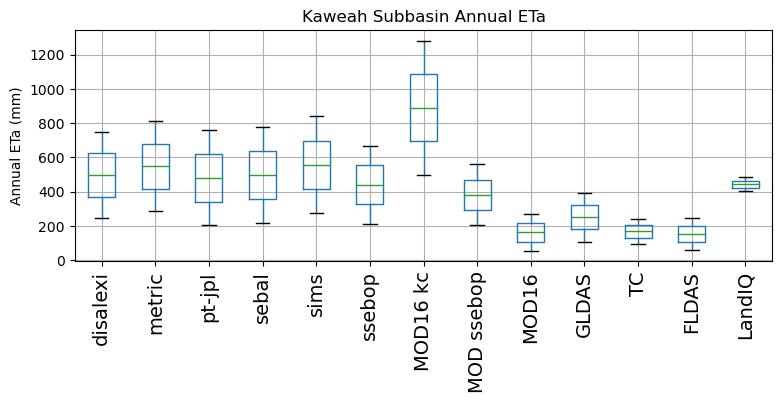

In [88]:
# plot the annual means irrespective of overlap

def annual_allyears(df, var = "ET"):

    annual_dfs = []

    for col_name in df.columns:

        tdf = df[col_name]

        ydf = pd.DataFrame(tdf.dropna()).resample("Y").sum()
        sumdf = pd.DataFrame([ydf.mean(),ydf.std()]).T
        sumdf.columns = ['mean','std']
        annual_dfs.append(sumdf)
        
    ydf_mean = pd.concat(annual_dfs).T
    
    return ydf_mean

ydf_mean = annual_allyears(etdf_final * 1e6 / k_area_km2)

fig = plt.figure(figsize = (9,3))
ax1 = fig.add_subplot(111)

ydf_mean.boxplot(ax = ax1)
ax1.set_ylabel("Annual ETa (mm)")
ax1.set_xticklabels(list(ydf_mean.rename(columns = etcoldictf).columns),rotation = 90, fontsize = 14)
ax1.set_title("Kaweah Subbasin Annual ETa")

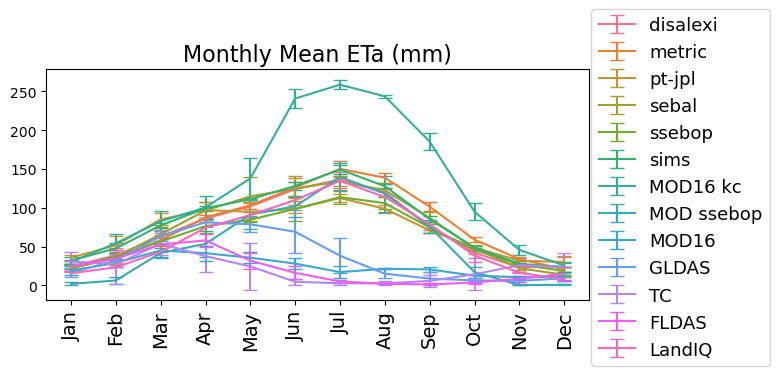

In [102]:
# plot the monthly means

coldict = etcoldictf.copy()
df = etdf_final.rename(columns = etcoldictf).copy() * 1e6 / k_area_km2

colors = sns.color_palette("husl", len(df.columns))
cdict = OrderedDict(zip(list(coldict.values()),colors))

fig = plt.figure(figsize = (7,3))
ax2 = fig.add_subplot(111)

monthly = df.groupby(df.index.month).mean()
errs= df.groupby(df.index.month).std()

for k,v in cdict.items():
    ax2.errorbar(monthly.index,monthly[k],capsize=5, color = v, yerr = errs[k], label = k)

labels = [dt_date(1900, x, 1).strftime('%B')[:3] for x in df.groupby(df.index.month).mean().index]
ax2.set_xticks(ticks = df.groupby(df.index.month).mean().index)
ax2.set_xticklabels(labels,rotation = 90, fontsize = 14)
ax2.set_title("Monthly Mean ETa (mm)", size = 16)

plt.legend(loc="upper right", ncol = 1,bbox_to_anchor=(1.35, 1.3),
           fancybox=True,  prop={'size': 13})

plt.style.use('default')

plt.show()

<AxesSubplot:>

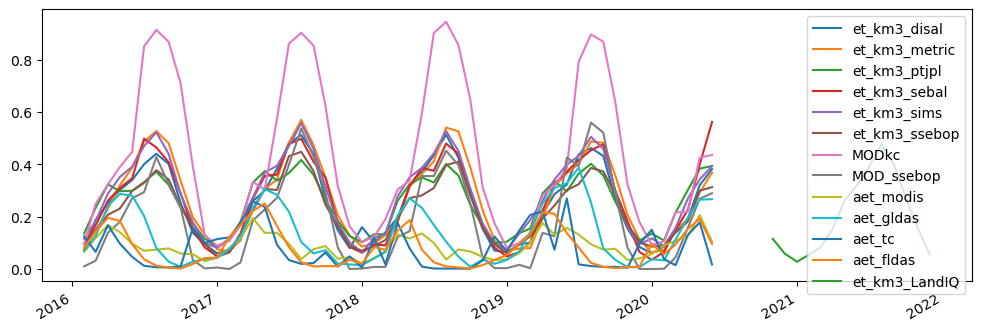

In [107]:
fig = plt.figure(figsize = (12,4))
ax = plt.subplot(111)
etdf_final.plot(ax = ax)

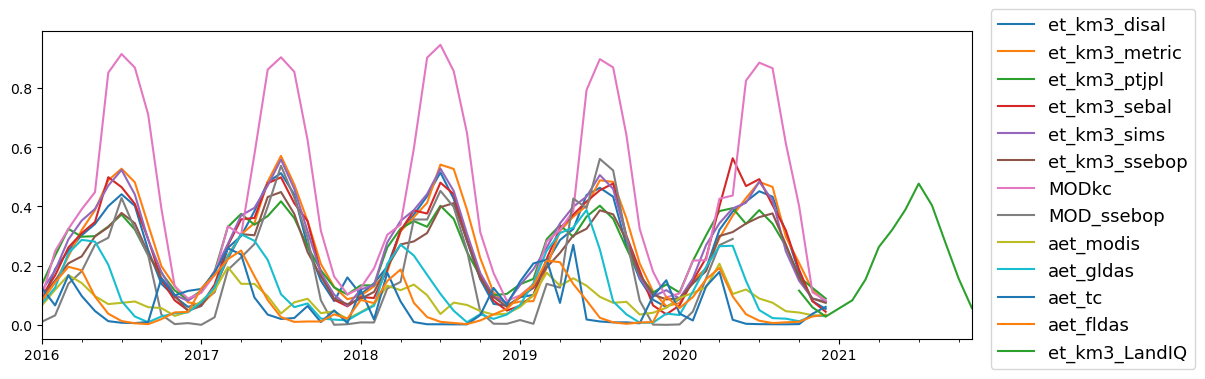

In [114]:

# Merge all 
etdf1t = pd.merge(etdf_all, modkc_et,how = 'outer',left_index = True, right_index = True)
etdf2t = pd.merge(etdf1t, ssebop_et,how = 'outer',left_index = True, right_index = True)
etdf_allt = pd.merge(etdf2t, kawdf_et,how = 'outer',left_index = True, right_index = True)
tsdf = pd.merge(etdf_allt, liqdf, how = 'outer', left_index = True, right_index = True).iloc[192:]

fig = plt.figure(figsize = (12,4))
ax = plt.subplot(111)
tsdf.plot(ax = ax)
plt.legend(loc="upper right", ncol = 1,bbox_to_anchor=(1.25, 1.1),
           fancybox=True,  prop={'size': 13})
